In [1]:
# ============================================================
# [BLOQUE 1] GENERACIÓN DE DATOS SINTÉTICOS — RLC SERIE (KVL)
# Salida que usaremos en la PINN: q(t) (carga)
# Opciones de entrada: escalón y coseno
#
# EDO (en q):
#   L q''(t) + R q'(t) + (1/C) q(t) = E(t)
# con i(t)=q'(t)
#
# Forma de 1er orden (estado X=[q, i]):
#   q' = i
#   i' = ( E(t) - R i - (1/C) q ) / L
# ============================================================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# -----------------------------
# Parámetros del circuito
# -----------------------------
L, R, C = 0.59, 0.76, 0.66   # <-- ajusta a tus valores (ejemplo)

# -----------------------------
# Entradas E(t)
# -----------------------------
def E_cero(t, **kwargs):
    return 0.0

def E_escalon(t, A=1.0, t0=1.0, **kwargs):
    return A if t >= t0 else 0.0

def E_coseno(t, A=1.0, w=2.0, t0=1.0, **kwargs):
    # Coseno activado desde t0 (antes es 0)
    return 0.0 if t < t0 else A * np.cos(w * (t - t0))

# -----------------------------
# Dinámica RLC en 1er orden
# -----------------------------
def rlc_serie_1er_orden(t, X, E_fun, E_kwargs, L, R, C):
    q, i = X  # q(t) carga, i(t)=dq/dt corriente
    Et = E_fun(t, **E_kwargs)
    dq_dt = i
    di_dt = (Et - R * i - (1.0 / C) * q) / L
    return [dq_dt, di_dt]

# -----------------------------
# Generador de datos sintéticos
# -----------------------------
def generar_datos_rlc(
    nombre="CASO",
    E_fun=E_cero,
    E_kwargs=None,
    t_inicio=0.0,
    t_final=10.0,
    n_puntos=2000,
    q0=0.0,          # q(0)
    i0=0.0,          # i(0)=q'(0)
    sigma_ruido_q=0.0,  # ruido gaussiano en q(t)
    seed=123,
    L=L, R=R, C=C
):
    if E_kwargs is None:
        E_kwargs = {}

    t_eval = np.linspace(t_inicio, t_final, n_puntos)

    sol = solve_ivp(
        fun=lambda t, X: rlc_serie_1er_orden(t, X, E_fun, E_kwargs, L, R, C),
        t_span=(t_inicio, t_final),
        y0=[q0, i0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-8,
        atol=1e-10,
    )

    t = sol.t
    q = sol.y[0]
    i = sol.y[1]
    E = np.array([E_fun(ti, **E_kwargs) for ti in t])

    # Ruido (opcional) en q(t)
    if sigma_ruido_q > 0:
        rng = np.random.default_rng(seed)
        q = q + rng.normal(0.0, sigma_ruido_q, size=q.shape)

    df = pd.DataFrame({
        "caso": nombre,
        "t": t,
        "q": q,
        "i": i,
        "E": E,
        "L": L,
        "R": R,
        "C": C
    })
    return df

# -----------------------------
# Ejemplos de datasets (2 opciones: escalón y coseno)
# -----------------------------
df_escalon = generar_datos_rlc(
    nombre="ESCALON",
    E_fun=E_escalon,
    E_kwargs={"A": 1.0, "t0": 1.0},
    q0=0.0, i0=0.0,
    sigma_ruido_q=0.0
)

df_coseno = generar_datos_rlc(
    nombre="COSENO",
    E_fun=E_coseno,
    E_kwargs={"A": 1.0, "w": 2.0, "t0": 1.0},
    q0=0.0, i0=0.0,
    sigma_ruido_q=0.0
)

df_todos_rlc = pd.concat([df_escalon, df_coseno], ignore_index=True)

print("Casos disponibles:", df_todos_rlc["caso"].unique())
df_todos_rlc.tail(10)


Casos disponibles: ['ESCALON' 'COSENO']


,caso,t,q,i,E,L,R,C
3990,COSENO,9.954977,-0.570852,0.139402,0.590110,0.59,0.76,0.66
3991,COSENO,9.959980,-0.570126,0.150834,0.598158,0.59,0.76,0.66
3992,COSENO,9.964982,-0.569343,0.162250,0.606146,0.59,0.76,0.66
3993,COSENO,9.969985,-0.568503,0.173650,0.614073,0.59,0.76,0.66
3994,COSENO,9.974987,-0.567606,0.185032,0.621938,0.59,0.76,0.66
3995,COSENO,9.979990,-0.566652,0.196395,0.629742,0.59,0.76,0.66
3996,COSENO,9.984992,-0.565641,0.207738,0.637482,0.59,0.76,0.66
3997,COSENO,9.989995,-0.564574,0.219061,0.645158,0.59,0.76,0.66
3998,COSENO,9.994997,-0.563449,0.230361,0.652770,0.59,0.76,0.66
3999,COSENO,10.000000,-0.562269,0.241638,0.660317,0.59,0.76,0.66


Casos disponibles: ['ESCALON' 'COSENO']


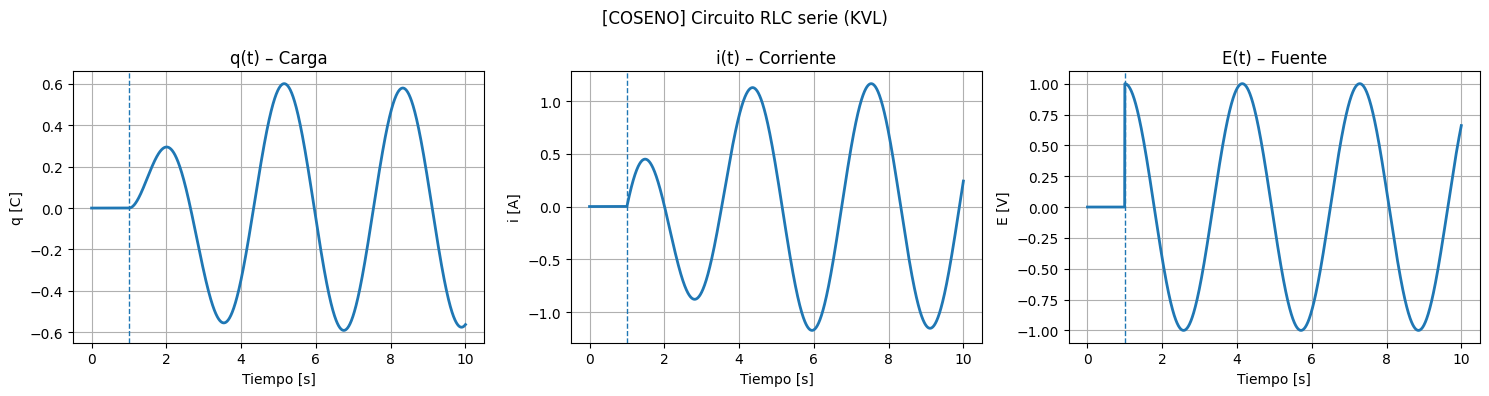

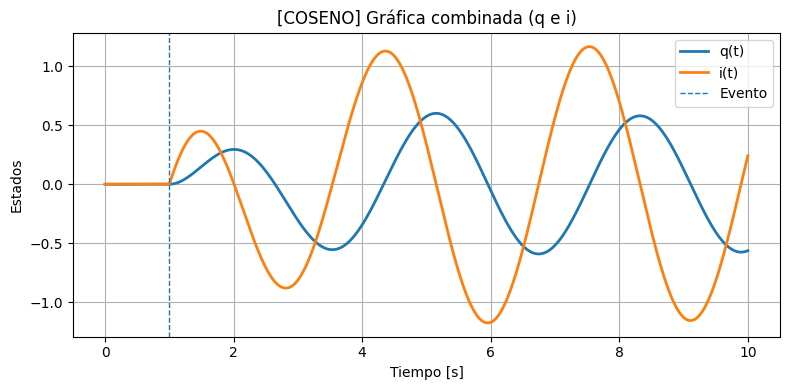

In [3]:
# ============================================================
# [BLOQUE 2] VISUALIZACIÓN DE DATOS SINTÉTICOS — RLC SERIE (df_todos_rlc)
# Grafica: q(t), i(t) y E(t) para un caso
# ============================================================

import matplotlib.pyplot as plt

# -----------------------------
# (1) Casos disponibles
# -----------------------------
casos_rlc = df_todos_rlc["caso"].unique()
print("Casos disponibles:", casos_rlc)

# -----------------------------
# (2) Función única de graficación
# -----------------------------
def plot_rlc(df, caso, t_evento=None):
    """
    Grafica q(t), i(t) y E(t) para un caso del circuito RLC serie.

    Parámetros:
    - df : DataFrame con columnas ['caso','t','q','i','E']
    - caso : nombre del caso a graficar (str)
    - t_evento : instante a marcar (opcional), ej. t0 del escalón/coseno
    """
    d = df[df["caso"] == caso].sort_values("t")
    if d.empty:
        raise ValueError(f"Caso '{caso}' no encontrado.")

    t = d["t"].to_numpy()
    q = d["q"].to_numpy()
    i = d["i"].to_numpy()
    E = d["E"].to_numpy()

    # --- 3 gráficas en línea ---
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

    ax[0].plot(t, q, lw=2)
    ax[0].set_title("q(t) – Carga")
    ax[0].set_xlabel("Tiempo [s]")
    ax[0].set_ylabel("q [C]")
    ax[0].grid(True)

    ax[1].plot(t, i, lw=2)
    ax[1].set_title("i(t) – Corriente")
    ax[1].set_xlabel("Tiempo [s]")
    ax[1].set_ylabel("i [A]")
    ax[1].grid(True)

    ax[2].plot(t, E, lw=2)
    ax[2].set_title("E(t) – Fuente")
    ax[2].set_xlabel("Tiempo [s]")
    ax[2].set_ylabel("E [V]")
    ax[2].grid(True)

    if t_evento is not None and (t.min() <= t_evento <= t.max()):
        for a in ax:
            a.axvline(t_evento, ls="--", lw=1)

    plt.suptitle(f"[{caso}] Circuito RLC serie (KVL)", fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- Gráfica combinada (q e i) ---
    plt.figure(figsize=(8, 4))
    plt.plot(t, q, label="q(t)", lw=2)
    plt.plot(t, i, label="i(t)", lw=2)

    if t_evento is not None and (t.min() <= t_evento <= t.max()):
        plt.axvline(t_evento, ls="--", lw=1, label="Evento")

    plt.xlabel("Tiempo [s]")
    plt.ylabel("Estados")
    plt.title(f"[{caso}] Gráfica combinada (q e i)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# (3) Uso
# -----------------------------
# Si tu escalón/coseno arranca en t0=1.0, márcalo:
plot_rlc(df_todos_rlc, caso="COSENO", t_evento=1.0)
# plot_rlc(df_todos_rlc, caso="COSENO",  t_evento=1.0)


In [5]:
!pip -q install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.0 MB/s eta 0:00:00


[INFO] Caso: COSENO | L=0.59, R=0.76, C=0.66 | q0=0.0, i0=0.0
[INFO] Dominio: [0.0, 10.0] con 2000 puntos de referencia
Compiling model...
'compile' took 0.009041 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7cbf28aef100>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7cbf28aef100>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                  Test loss                                   Test metric
0         [1.35e+00, 0.00e+00, 4.32e-01, 3.94e+01]    [1.35e+00, 0.00e+00, 4.32e-01, 3.94e+01]    []  
200       [4.18e-01, 7.56e-03, 2.34e-02, 1.72e+01]    [4.18e-01, 7.56e-03, 2.34e-02, 1.72e+01]    []  
400       [4.18e-01, 7.48e-03, 2.24e-02, 1.72e+01]    [4.18e-01, 7.48e-03, 2.24e-02, 1.72e+01]    []  
600       [4.18e-01, 7.17e-03, 2.25e-02, 1.72e+01]    [4.18e-01, 7.17e-03, 2.25e-02, 1.72e+01]   

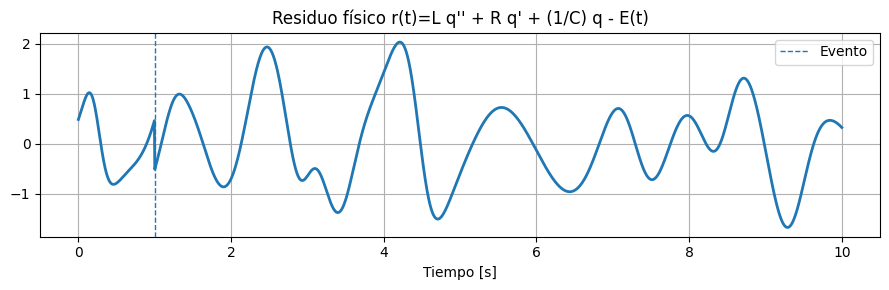

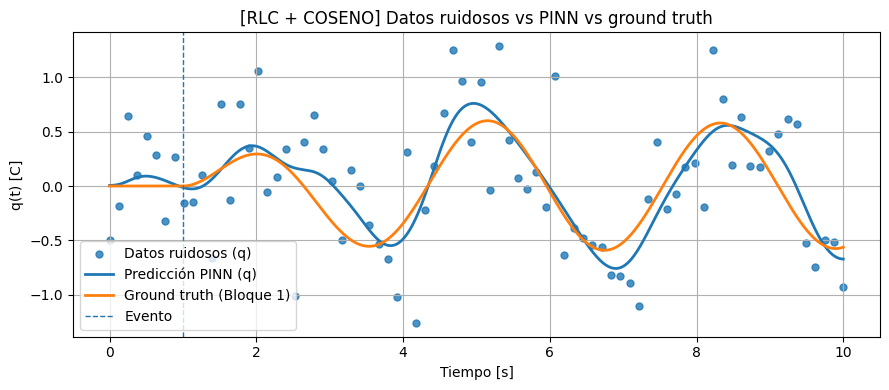

[LOSS final train]: [5.4969543e-01 2.4908801e-04 2.1360302e-03 8.3315830e+00]
Backend DeepXDE: tensorflow


In [9]:
# ============================================================
# [BLOQUE 3] PINN (DeepXDE) — RLC SERIE (KVL)
# Salida de la red: q(t)  (carga)
# Datos: se toman de df_todos_rlc (Bloque 1) y SOLO se agrega ruido
#
# EDO en q(t):
#   L q''(t) + R q'(t) + (1/C) q(t) = E(t)
#
# Entrenamiento: PDE + IC(q0, i0) + Datos ruidosos de q(t)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf

# -----------------------------
# [B1] Configuración general
# -----------------------------
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# === Elegir caso del dataset (Bloque 1) ===
CASO = "COSENO"   # "ESCALON" o "COSENO"
t_evento = 1.0     # para marcar en gráficas (si aplica)

# === Muestreo de datos observados (a partir del ground truth ya simulado) ===
n_datos = 80
sigma_ruido_q = 0.5  # ruido gaussiano agregado SOLO a los datos observados

# === Sampling PINN (física) ===
num_fisica = 400
num_boundary = 20

# Pesos: [PDE, IC_pos (q0), IC_vel (i0), DATA]
loss_weights = [1.0, 10.0, 10.0, 50.0]

# Opcional: anchors (más puntos físicos cerca de t0)
USAR_ANCHORS = True
ANCHOR_WINDOW = 0.15
N_ANCHORS = 120

# -----------------------------
# [B2] Cargar ground truth desde df_todos_rlc (Bloque 1)
# -----------------------------
d = df_todos_rlc[df_todos_rlc["caso"] == CASO].sort_values("t")
if d.empty:
    raise ValueError(f"El caso '{CASO}' no existe en df_todos_rlc. Casos: {df_todos_rlc['caso'].unique()}")

# Señales "true" del simulador (ya calculadas en Bloque 1)
t_eval = d["t"].to_numpy()
q_true = d["q"].to_numpy()
i_true = d["i"].to_numpy()
E_eval = d["E"].to_numpy()

# Parámetros (constantes) del caso
L = float(d["L"].iloc[0])
R = float(d["R"].iloc[0])
C = float(d["C"].iloc[0])

# Tiempo del dominio (se toma del dataset)
t_inicio = float(t_eval.min())
t_final  = float(t_eval.max())

# Condiciones iniciales desde el dataset
# (así te aseguras consistencia con la simulación del Bloque 1)
q0 = float(q_true[0])
i0 = float(i_true[0])

print(f"[INFO] Caso: {CASO} | L={L}, R={R}, C={C} | q0={q0}, i0={i0}")
print(f"[INFO] Dominio: [{t_inicio}, {t_final}] con {len(t_eval)} puntos de referencia")

# -----------------------------
# [B3] Construir observaciones: submuestreo + ruido (SIN re-simular EDO)
# -----------------------------
# Submuestreo uniforme de índices sobre el ground truth
idx = np.linspace(0, len(t_eval) - 1, n_datos).astype(int)
t_datos = t_eval[idx]
q_datos_true = q_true[idx]

# Agregar ruido SOLO a observaciones
rng = np.random.default_rng(SEED)
q_ruidoso = q_datos_true + rng.normal(0.0, sigma_ruido_q, size=q_datos_true.shape)

# DeepXDE requiere (N,1)
t_datos_dd = t_datos.reshape(-1, 1)
q_ruidoso_dd = q_ruidoso.reshape(-1, 1)

# -----------------------------
# [B4] Definir E(t) en TensorFlow para la PDE
# -----------------------------
# Como E(t) ya está disponible como serie (t_eval, E_eval),
# lo más eficiente/seguro es:
#   - asumir que el caso es escalón o coseno (como en Bloque 1)
#   - definir E_tf(t) de forma analítica (evita interpolación TF)
#
# Si más adelante quieres E(t) arbitraria (tabla), te armo la versión con interpolación.

# Detectar tipo de caso para definir E_tf(t)
# (mantenemos exactamente las mismas expresiones del Bloque 1)
def E_tf(t):
    t0 = tf.constant(t_evento, dtype=t.dtype)

    # Intentamos inferir A y w desde el dataset para no re-escribirlos a mano
    A_est = float(np.max(np.abs(E_eval))) if np.max(np.abs(E_eval)) > 0 else 1.0
    A = tf.constant(A_est, dtype=t.dtype)

    if CASO.upper() == "ESCALON":
        return tf.where(t >= t0, A * tf.ones_like(t), tf.zeros_like(t))

    elif CASO.upper() == "COSENO":
        # Estimar w (muy básico): si sabes w, ponlo fijo mejor.
        # Aquí lo dejamos fijo a 2.0 por coherencia con Bloque 1, si fue así.
        w = tf.constant(2.0, dtype=t.dtype)
        return tf.where(t < t0, tf.zeros_like(t), A * tf.cos(w * (t - t0)))

    else:
        # fallback: 0
        return tf.zeros_like(t)

# -----------------------------
# [B5] Definir PINN: PDE + IC + Datos
# -----------------------------
geom = dde.geometry.TimeDomain(t_inicio, t_final)

# PDE residual: L q'' + R q' + (1/C) q - E(t) = 0
def pde_rlc(t, q):
    q_t  = dde.grad.jacobian(q, t, i=0, j=0)   # q'
    q_tt = dde.grad.hessian(q, t, i=0, j=0)    # q''
    return L * q_tt + R * q_t + (1.0 / C) * q - E_tf(t)

# Indicador de condición inicial
def on_initial(t, is_initial):
    return is_initial

# IC: q(0)=q0
ic_q = dde.icbc.IC(geom, lambda t: q0, on_initial)

# IC: q'(0)=i0
def ic_i_operator(t, q, _):
    q_t = dde.grad.jacobian(q, t, i=0, j=0)
    return q_t - i0

ic_i = dde.icbc.OperatorBC(geom, ic_i_operator, on_initial)

# Observaciones: q(t_i) ≈ q_ruidoso
obs_q = dde.icbc.PointSetBC(t_datos_dd, q_ruidoso_dd, component=0)

# Anchors cerca del evento (opcional)
anchors = None
if USAR_ANCHORS:
    t_left = max(t_inicio, t_evento - ANCHOR_WINDOW)
    t_right = min(t_final, t_evento + ANCHOR_WINDOW)
    anchors = np.linspace(t_left, t_right, N_ANCHORS).reshape(-1, 1)

data = dde.data.TimePDE(
    geom,
    pde_rlc,
    [ic_q, ic_i, obs_q],
    num_domain=num_fisica,
    num_boundary=num_boundary,
    anchors=anchors
)

# Red
net = dde.nn.FNN([1, 64, 64, 64, 1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# -----------------------------
# [B6] Entrenamiento (Adam -> L-BFGS)
# -----------------------------
model.compile("adam", lr=5e-4, loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=8000, display_every=200)

model.compile("L-BFGS", loss_weights=loss_weights)
losshistory, train_state = model.train()

# -----------------------------
# [B7] Evaluación: predicción + métricas + residuo físico
# -----------------------------
t_eval_dd = t_eval.reshape(-1, 1)

q_pinn = model.predict(t_eval_dd).reshape(-1)

# Métricas vs ground truth (del Bloque 1)
y_true = q_true
y_pred = q_pinn

mse = np.mean((y_pred - y_true) ** 2)
mae = np.mean(np.abs(y_pred - y_true))
r2 = 1.0 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

print(f"[MÉTRICAS] MAE={mae:.4e} | MSE={mse:.4e} | R2={r2:.6f}")

# Residuo físico r(t)
r = model.predict(t_eval_dd, operator=pde_rlc).reshape(-1)

plt.figure(figsize=(9, 3))
plt.plot(t_eval, r, lw=2)
plt.axvline(t_evento, ls="--", lw=1, label="Evento")
plt.title("Residuo físico r(t)=L q'' + R q' + (1/C) q - E(t)")
plt.xlabel("Tiempo [s]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Comparación visual
plt.figure(figsize=(9, 4))
plt.scatter(t_datos, q_ruidoso, s=25, alpha=0.8, label="Datos ruidosos (q)")
plt.plot(t_eval, q_pinn, lw=2, label="Predicción PINN (q)")
plt.plot(t_eval, q_true, lw=2, label="Ground truth (Bloque 1)")
plt.axvline(t_evento, ls="--", lw=1, label="Evento")
plt.xlabel("Tiempo [s]")
plt.ylabel("q(t) [C]")
plt.title(f"[RLC + {CASO}] Datos ruidosos vs PINN vs ground truth")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Pérdidas finales
print("[LOSS final train]:", losshistory.loss_train[-1])

# Backend (robusto)
try:
    print("Backend DeepXDE:", dde.backend.backend_name())
except Exception:
    print("Backend DeepXDE:", getattr(dde.backend, "backend_name", "desconocido"))
